# CUnumeric-based Navier-Stokes solver

In this hands-on demo, we will implement a simple Navier Stokes
finite-difference solver based on CUnumeric. Since CUnumeric is a drop-in
replacement for Numpy, this is (supposed to be) very easy! We will also evaluate the performance of our application using
tools provided by Legate, and test more efficient implementations of our solver.

1. [Introduction](#introduction) (What are Cunumeric and Legate? + useful resources)
2. [Getting started](#getting-started) (How to install and run Cunumeric)
3. [A simple Navier-Stokes solver](#a-simple-navier-stokes-solver)
4. [Performance](#performance-evaluation) (evaluation, profiling)
5. [A better implementation](#a-better-implementation) (?)
6. [Add some Machine Learning](#add-some-machine-learning)
7. [Use of heterogeneous resources](#use-heterogeneous-resources) (how to dispatch computations to GPUs/CPUs)

For any question, feel free to contact me at [cl2292@stanford.edu](mailto:cl2292@stanford.edu), or directly
reach out to the [Legate](https://github.com/nv-legate/legate.core) or
[CUnumeric](https://github.com/nv-legate/cunumeric) developers. If you need
help (e.g. API coverage, best practice, etc...), the most useful resource is the [Cunumeric documentation](https://nv-legate.github.io/cunumeric/23.11/).

## Introduction

See [slides](../slides/Legion_cunumeric_demo.pptx).

## Getting started

Note: Since CUnumeric is a drop-in replacement for Numpy, you can first
write your application in vanilla Numpy, and then install CUnumeric later.

First case (the easy one), if you have a linux-64 system, and have either an
Nvidia GPU Volta or later (or if you do not intend to use GPU support), then
Cunumeric and Legate are available as a Conda package:
```console
conda install -c nvidia -c conda-forge -c legate cunumeric
```

Otherwise, you need to first build Legate from source, based on [this
guide](https://github.com/nv-legate/legate.core/blob/branch-24.01/BUILD.md). It
is strongly advised to build Legate in a conda environment.
```console
git clone https://github.com/nv-legate/legate.core.git
```
Legate provides a script to help you set-up a conda environment (replace the
python version and OS with appropriate values, run the script with `--help` to
see all available options):
```console
./scripts/generate-conda-envs.py --python 3.10 --os osx
```
After installing the dependencies, Legate can be built with:
```console
./install.py --max-dim 4 --openmp --clean
```

After completing the installation of Legate, you can clone and build Cunumeric:

```console
git clone https://github.com/nv-legate/cunumeric.git
```

then:

```console
./install.py --max-dim 4 --openmp --clean
```

__Running Legate__

There are several ways to run Legate:
1. In a Jupyter notebook (limited to single node execution)
2. Using the standard Python interpreter (limited to single node execution)
3. Using the `legate` driver (for multi-node execution and more fine-grained control)

This notebook can be executed locally, or on a supercomputer, following [these instructions](https://nv-legate.github.io/legate.core/README.html#running-with-jupyter-notebook).

## A simple Navier-Stokes solver

We will implement a solver that integrates the three-dimensional, compressible, single-component Navier-Stokes equations
for an ideal gas. These equations and numerical integration are detailed below.

<img src="../images/NS_equation.png" width="700">
<img src="../images/diffusion_flux.png" width="700">

In [2]:
# Import Cunumeric instead of numpy
import cunumeric as num
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Define some constants
constants = {
    "grid": (64,) * 3,
    "grid_ghost": (64 + 2,) * 3,
    "length": 1.0,
    "rho_0": 1.0,
    "p_0": 1e5,
    "T_0": 300.0,
    "gamma": 1.4,
    "r_gas": 8.3144598 / 32e-3,
    "mu": 2.0e-5,
    "lambda": 0.026,
    "forcing_amplitude": 0.5,
    "dt": 1e-5
}

[0 - 102a04580]    0.000080 {4}{threads}: reservation ('CPU proc 1d00000000000003') cannot be satisfied


### Convection fluxes

First let's implement a function that computes the convection fluxes for the 5
flow variables.

<img src="../images/Convection_fluxes.png" width="700">

In [3]:
def convection(rho, rhou, rhoE):
    pass

### Diffusion fluxes

Now let's implement the diffusion fluxes. Those require a little more
operations, so feel free to skip and directly copy-paste the function from the
solution notebook.

<img src="../images/numerical_diffusion_flux.png" width="700">

In [4]:
def diffusion(rho, rhou, rhoE, dwdt):
    pass

### Initial conditions and forcing

The flow that we are trying to simulate if a homogeneous isotropic turbulence
(HIT). In order to obtain such flow, we need to set a specific initial solution:

<img src="../images/initialization.png" width="400">


<img src="../images/forcing.png" width="500">

In [5]:
def initialization(rho, rhou, rhoE, x, y, z):
    pass

def forcing(rhou):
    pass   

### Boundary conditions

The simulation of HIT requires periodic boundary conditions in every
directions, which we achieve by imposing the values of the flow variables in
the ghost cells surrounding the domain.

In [6]:
def boundary_conditions(rho, rhou, rhoE):
    pass

### Wrap it up

We can now combine the functions computing the different terms above in a
temporal loop where the solution is updated by on a 1st-order Euler scheme.

<img src="../images/euler.png" width="150">

In [9]:
def run_simulation(niter):
    pass


In [10]:
rho, rhou, rhoE, x, y, z = run_simulation(100)

Iteration: 0


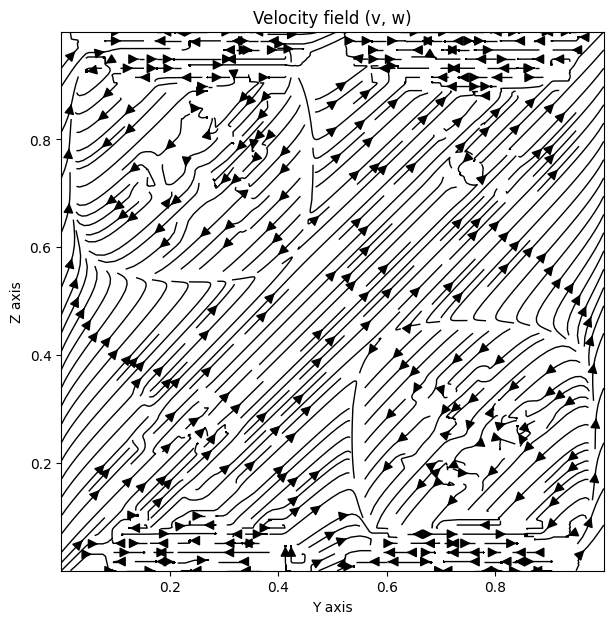

In [33]:
def make_plot(rho, rhou, rhoE, x, y, z):
    
    # Index of the 2D plane
    i = rho.shape[0] // 4
    
    # Grid
    # Y = num.repeat(y[0, :, 0], z[0, 0, :].shape[0], axis=0)
    # Z = num.repeat(z[0, 0, :], y[0, :, 0].shape[0], axis=0)
    Y = np.repeat(np.asarray(y[:, 1:-1, 0]), z[0, 0, 1:-1].shape[0], axis=0)
    Z = np.swapaxes(np.repeat(np.asarray(z[:, 0, 1:-1]), z[0, 0, 1:-1].shape[0], axis=0), 0, 1)

    # Velocity field
    U = rhou[1, i, 1:-1, 1:-1] / rho[i, 1:-1, 1:-1]
    V = rhou[2, i, 1:-1, 1:-1] / rho[i, 1:-1, 1:-1]

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(7, 7))

    # Streamline plot
    strm = ax.streamplot(
        Y, Z, U, V, color='k',
        linewidth=1, density=2,
        arrowstyle='-|>', arrowsize=1.5)

    ax.set_title('Velocity field (v, w)')
    ax.set_xlabel('Y axis')
    ax.set_ylabel('Z axis')
    ax.grid(False)
    ax.set_xlim([Y[0, 0], Y[0, -1]])
    ax.set_ylim([Z[0, 0], Z[-1, 0]])

    # Show plot
    plt.show()

make_plot(rho, rhou, rhoE, x, y, z)

## Performance evaluation

Since Legion is an asynchronous distributed system, measuring runtime of an
application should not be done with the usual `time` python module. Instead,
legate provides a replacement for the `time` module. In addition, the Legion
runtime usually requires a "warmup" time, after which the runtime per iteration
becomes shorter (e.g. due to tracing). We then need to re-write the code to
exclude the execution time of the initialization and the first few iterations.

In [47]:
from legate.timing import time

def run_simulation(niter):
    pass

In [48]:
rho, rhu, rhoE = run_simulation(100)

Iteration: 0
Runtime = 127.39672222222222 ms/iteration


Another useful tool to evaluate the performance of an application is profiling.
Legion provides its own profiler to visualize the execution of tasks across
multiple nodes and processors. To generate profiles when running a legate
script, just add the option `--profile` to the legate driver.

Some pre-generated profiles can be located [there](../profiles/).
To visualize the profiles in an interactive GUI, run:

```console
legion_prof --view legate_*.prof
```

## A better implementation

Our Navier-Stokes solver can be run with either numpy or cunumeric without any
code modification. However, if you run locally or with limited processor count,
you might have noticed that our solver is even slower than cunumeric to
execute!

There are indeed some caveats to consider when implementing a cunumeric code:

1. Each cunumeric operator launches 1 or multiple Legion tasks. Each Legion task
   induces runtime overhead. It is therefore recommended to group cunumeric
   operators. The recommended granularity is to have tasks executing in at least
   ~ 1 ms.

2. Cunumeric operations such as `a = b + c + d` create temporary regions to
   store the intermediate results. Those can reside in memory until they are
   garbage collected,which increases the overall memory usage of the application.

3. In some cases (e.g. if the operator is not implemented in cunumeric),
   cunumeric may fall back silently to the numpy operator. This one may be
   slower and/or induce significant data transfer from the memories where the
   cunumeric array is mapped to the local address space where the numpy array is mapped. 

4. When slicing or indexing a numpy array, numpy usually returns a view of the
   data rather than a copy. Cunumeric tries to do the same, but when not
   possible, slicing or indexing may return a copy of the data, which increases
   the memory consumption.

5. Conditional statements, such as: `if x < y:`, will block the execution of
   the runtime until both `x` and `y` become available. Such blocking
   statements should be avoided as much as possible (or at least done as
   sparingly as possible).

Generally speaking, it is advised to group operators as well as to use inplace
operations when possible (e.g. use the `out` argument of the operators).


We can now try to re-write a better version of our Navier-Stokes solver.

In [ ]:
def center_to_face(dir, x, out=None, inplace=False):
    pass


def compute_pressure(rhoE, rho):
    pass


def convection_better(rho, rhou, rhoE):
    pass

## Use heterogeneous resources

Legion and Legate can run efficiently on heterogeneous architectures thanks to
a customizable mapping interface, which defines policies determining on which
processors tasks should run and to which memories physical instances of the
regions should be mapped.

In addition, Legate offers a high-level construct to customize mapping policies
through a resource scoping context manager.

Let's see how we can run some part of our CFD solver on the CPUs, while the
other terms are still computed on the GPUs.

In [10]:
from legate.core import get_machine

def run_simulation(niter):

    # Get the machine configuration
    machine = get_machine()
    OMPs = machine.only("OMP")
    GPUs = machine.only("GPU")
    CPUs = machine.only("CPU")
    
    pass
    

    

In [ ]:
rho, rhou, rhoE, x, y, z = run_simulation(100)